In [228]:
import pandas as pd
import numpy as np
from pathlib import Path
from typing import Union, List
from datetime import timedelta

ETF_DATA_FILEPATH = "../data/raw/Bloomberg ETFs Cleaned.xlsx"
STOCKS_DATA_FILEPATH = "../data/raw/stocks_etfs.xlsx"

In [229]:
rawData_df = pd.read_excel(ETF_DATA_FILEPATH, sheet_name='all_etf', index_col=0, parse_dates=True)
rawData_df.columns = [x.split()[0] for x in rawData_df.columns]
stocks_rawData_df = pd.read_excel(STOCKS_DATA_FILEPATH, sheet_name='all_assets_price', index_col=0, parse_dates=True)
stocks_rawData_df.columns = [x.split()[0] for x in stocks_rawData_df.columns]

start_date = stocks_rawData_df.dropna().first_valid_index() + timedelta(days=1)
start_date

Timestamp('2007-01-12 00:00:00')

<Axes: title={'center': 'GOVT Price Time Series'}, xlabel='Date'>

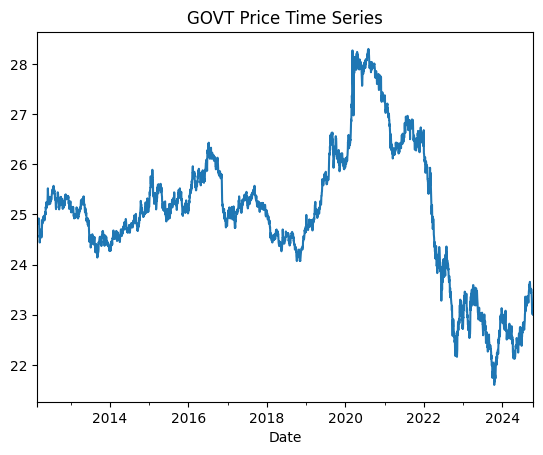

In [230]:
rawData_df['GOVT'].dropna().plot(title='GOVT Price Time Series')

In [231]:
etf_rets = rawData_df.pct_change()
stocks_rets = stocks_rawData_df.pct_change().dropna()

valid_index = etf_rets.apply( lambda x: x.first_valid_index())
etf_rets = etf_rets.loc[start_date:, valid_index <= start_date]

# Remove rfr
etf_ex_rets = etf_rets.subtract(stocks_rets['SHV'], axis=0)
stocks_ex_rets = stocks_rets.subtract(stocks_rets['SHV'], axis=0).drop(columns=['SHV'])

In [232]:
# do sma (periods)
# Run on our raw data
# Choose one EQUITY / FI -> 60/40 portfolio -> returns
# rerun on sma model to get performance metrics (mean, vol, sharpe)

# 11 stocks + 3 broad etf (GOLD, HYG, TIPS) -> run on sma individually get performane metrics ( mean vol sharpe) then rank
# correlation of matrix of above with  60/40 portfolio
# we add each into the original portfolio 80 / 20 new asset -> run sma again -> get metrics (mean vol sharpe) -> rank by sharpe
# Compare individual sharpe ranking vs portfolio sharpe -->

In [233]:
# Assuming that the input data is daily, window is rolling window for sma, period_factor is for annualization
# returns the sma returns df and the summary stats (Mean, Vol, Sharpe)
def get_sma_performance(rets,  window=20, annual_factor=252, var_quantile: Union[float, List] = .05):
    returns = rets.dropna().rolling(window=window).mean().dropna()
    
    summary_statistics = pd.DataFrame(index=returns.columns)
    summary_statistics['Mean'] = returns.mean()
    summary_statistics['Annualized Mean'] = returns.mean() * annual_factor
    summary_statistics['Vol'] = returns.std()
    summary_statistics['Annualized Vol'] = returns.std() * np.sqrt(annual_factor)
    ### To check for r.f.r.
    summary_statistics['Sharpe'] = returns.mean() / returns.std()
    summary_statistics['Annualized Sharpe'] = summary_statistics['Sharpe'] * np.sqrt(annual_factor)
    summary_statistics['Min'] = returns.min()
    summary_statistics['Max'] = returns.max()
    summary_statistics['Skewness'] = returns.skew()
    summary_statistics['Excess Kurtosis'] = returns.kurtosis()
    var_quantile = [var_quantile] if isinstance(var_quantile, (float, int)) else var_quantile
    for var_q in var_quantile:
        summary_statistics[f'Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0)
        summary_statistics[f'Annualized Historical VaR ({var_q:.2%})'] = returns.quantile(var_q, axis = 0) * np.sqrt(annual_factor)
        summary_statistics[f'Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean()
        summary_statistics[f'Annualized Historical CVaR ({var_q:.2%})'] = returns[returns <= returns.quantile(var_q, axis = 0)].mean() * np.sqrt(annual_factor)
    
    wealth_index = 1000 * (1 + returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks) / previous_peaks

    summary_statistics['Max Drawdown'] = drawdowns.min()
    summary_statistics['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_statistics['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_statistics['Recovery'] = recovery_date
    try:
        summary_statistics["Duration (days)"] = [
            (i - j).days if i != "-" else "-" for i, j in
            zip(summary_statistics["Recovery"], summary_statistics["Bottom"])
        ]
    except (AttributeError, TypeError) as e:
        print(f'Cannot calculate "Drawdown Duration" calculation because there was no recovery or because index are not dates: {str(e)}')

    return returns, summary_statistics

sma_rets, summary_stats = get_sma_performance(etf_ex_rets[['SPY', 'AGG']], window=20, annual_factor=252)
summary_stats

,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,Historical VaR (5.00%),Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Recovery,Duration (days)
SPY,0.000374,0.094126,0.002333,0.037032,0.160116,2.541770,-0.017574,0.01232,-1.480703,7.963019,-0.003555,-0.056438,-0.005916,-0.093917,-0.472547,2007-10-18,2009-03-17,2012-02-08,1058.0
AGG,0.000004,0.001102,0.000652,0.010349,0.006711,0.106528,-0.006801,0.00487,-0.260272,7.473156,-0.001060,-0.016830,-0.001552,-0.024642,-0.214547,2020-08-12,2023-10-31,NaT,NaN


<font color='red'>

#### 60/40 Portfolio performance - SPY/BNDX

</font>

In [234]:
etf_port_ex_rets = etf_ex_rets[['SPY', 'AGG']].dropna()
og_pf_weight = pd.DataFrame(index=['SPY', 'AGG'], columns=['Weights'])
og_pf_weight.loc['SPY', 'Weights'] = 0.6
og_pf_weight.loc['AGG', 'Weights'] = 0.4
og_pf_rets = etf_port_ex_rets @ og_pf_weight
og_pf_rets.rename(columns={'Weights': '60/40 (SPY/BNDX)'}, inplace=True)
og_pf_ex_rets_sma, summary_stats = get_sma_performance(og_pf_rets, window=20, annual_factor=252)
summary_stats

,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,Historical VaR (5.00%),Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Recovery,Duration (days)
60/40 (SPY/BNDX),0.000226,0.056917,0.001481,0.023505,0.15254,2.421501,-0.013026,0.008467,-1.54984,9.709815,-0.002208,-0.035053,-0.003741,-0.059383,-0.315297,2007-10-31,2009-03-17,2011-02-09,694


<font color='red'>

#### Do similar analysis to 11 stocks (1 from each sector) and 3 Broad Market ETFs ()

</font>

In [235]:
stocks_ex_rets_sma, summary_stats = get_sma_performance(stocks_ex_rets, window=20, annual_factor=252)
summary_stats

,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,Historical VaR (5.00%),Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Recovery,Duration (days)
VZ,0.000134,0.033779,0.002592,0.041151,0.051709,0.820850,-0.014180,0.012366,0.016570,0.981647,-0.003972,-0.063046,-0.005436,-0.086298,-0.449019,2020-12-09,2023-10-23,NaT,NaN
AMZN,0.001267,0.319389,0.004770,0.075714,0.265732,4.218368,-0.020895,0.024666,0.116214,2.266692,-0.006163,-0.097834,-0.009307,-0.147737,-0.459187,2021-07-29,2023-01-10,2024-01-02,357.0
PG,0.000273,0.068776,0.002181,0.034621,0.125140,1.986536,-0.010270,0.011086,-0.362913,1.329623,-0.003342,-0.053050,-0.004894,-0.077694,-0.334277,2008-01-01,2009-03-25,2012-04-04,1106.0
XOM,0.000245,0.061841,0.003351,0.053199,0.073228,1.162451,-0.028297,0.015167,-0.859354,7.829108,-0.004826,-0.076603,-0.007537,-0.119646,-0.601914,2014-07-30,2020-11-06,2022-02-21,472.0
JPM,0.000589,0.148337,0.004164,0.066103,0.141361,2.244032,-0.025442,0.034927,0.054386,6.561751,-0.005776,-0.091697,-0.009181,-0.145744,-0.367485,2007-05-22,2009-03-12,2009-04-20,39.0
JNJ,0.000248,0.062517,0.002146,0.034072,0.115584,1.834831,-0.012697,0.016168,-0.260991,3.105134,-0.003301,-0.052404,-0.004772,-0.075756,-0.270524,2008-09-03,2009-03-25,2011-07-22,849.0
HON,0.000467,0.117559,0.003390,0.053817,0.137605,2.184411,-0.024475,0.016938,-1.004061,6.849503,-0.004835,-0.076760,-0.008224,-0.130555,-0.532640,2008-05-21,2008-12-08,2010-12-13,735.0
MSFT,0.000716,0.180437,0.003126,0.049616,0.229089,3.636668,-0.013807,0.013915,-0.212427,1.091990,-0.004534,-0.071980,-0.006361,-0.100975,-0.466923,2008-01-03,2009-03-20,2009-12-04,259.0
SHW,0.000757,0.190739,0.003237,0.051381,0.233850,3.712252,-0.017601,0.015122,-0.389412,1.419288,-0.004675,-0.074218,-0.006945,-0.110250,-0.360004,2021-12-31,2022-10-21,2024-02-28,495.0
AVB,0.000318,0.080082,0.003587,0.056947,0.088586,1.406264,-0.028511,0.024058,-0.580064,6.554350,-0.005115,-0.081203,-0.008668,-0.137596,-0.554775,2007-02-20,2009-03-09,2010-01-07,304.0


In [236]:
sharpe_ranking = summary_stats['Sharpe'].sort_values(ascending=False).rename('Individual Sharpe').to_frame().reset_index(names='Ticker')
sharpe_ranking.index = sharpe_ranking.index + 1
sharpe_ranking = sharpe_ranking.reset_index(names='Individual Sharpe Rank')
sharpe_ranking = sharpe_ranking.set_index('Ticker')
display(sharpe_ranking)



,Individual Sharpe Rank,Individual Sharpe
Ticker,,
AMZN,1,0.265732
SHW,2,0.233850
MSFT,3,0.229089
VGT,4,0.219196
GLD,5,0.153265
JPM,6,0.141361
HON,7,0.137605
PG,8,0.125140
JNJ,9,0.115584


<font color='red'>

#### Include each stock in the original portfolio, 80/20 (48 Equity / 32 FI / 20 addition)

</font>

In [237]:
def get_weights(ticker, delta):
    # delta is the weight of the old portfolio
    weights = pd.DataFrame(index=['SPY', 'AGG'], columns=['Weights'])
    weights.loc['SPY', 'Weights'] = 0.6*delta
    weights.loc['AGG', 'Weights'] = 0.4*delta
    weights.loc[ticker, 'Weights'] = 1-delta
    return weights

new_pf_summ_stats = pd.DataFrame()

for ticker in stocks_ex_rets.columns:
    weights = get_weights(ticker, delta= 0.8).rename(columns={'Weights':ticker})
    ex_rets = pd.concat([etf_port_ex_rets, stocks_ex_rets[ticker]], axis=1)
    new_port_ex_rets = ex_rets @ weights
    stocks_ex_rets_sma, summary_stats = get_sma_performance(new_port_ex_rets, window=20, annual_factor=252)
    new_pf_summ_stats = pd.concat([new_pf_summ_stats, summary_stats], axis=0)
    
new_pf_summ_stats 

,Mean,Annualized Mean,Vol,Annualized Vol,Sharpe,Annualized Sharpe,Min,Max,Skewness,Excess Kurtosis,Historical VaR (5.00%),Annualized Historical VaR (5.00%),Historical CVaR (5.00%),Annualized Historical CVaR (5.00%),Max Drawdown,Peak,Bottom,Recovery,Duration (days)
VZ,0.000207,0.052289,0.001498,0.023788,0.138471,2.198159,-0.012871,0.008061,-1.292455,8.098549,-0.002255,-0.035799,-0.003750,-0.059537,-0.313774,2007-10-31,2009-03-16,2011-02-16,702
AMZN,0.000434,0.109411,0.001884,0.029902,0.230493,3.658964,-0.013352,0.009420,-0.964534,4.967987,-0.002746,-0.043598,-0.004442,-0.070515,-0.308962,2007-10-23,2008-12-05,2009-11-09,339
PG,0.000235,0.059289,0.001454,0.023086,0.161782,2.568212,-0.012439,0.008861,-1.459805,8.740120,-0.002184,-0.034674,-0.003680,-0.058411,-0.312475,2007-10-29,2009-03-20,2011-02-17,699
XOM,0.000230,0.057902,0.001626,0.025808,0.141332,2.243582,-0.014703,0.009807,-1.634327,11.853218,-0.002340,-0.037142,-0.004024,-0.063881,-0.286188,2007-10-31,2009-03-20,2011-02-02,684
JPM,0.000298,0.075201,0.001821,0.028911,0.163856,2.601126,-0.013452,0.011960,-0.936991,7.324226,-0.002808,-0.044576,-0.004382,-0.069563,-0.317805,2007-06-04,2009-03-16,2009-10-08,206
JNJ,0.000230,0.058037,0.001472,0.023363,0.156488,2.484163,-0.012732,0.009781,-1.370677,9.030661,-0.002147,-0.034086,-0.003618,-0.057430,-0.293408,2007-10-18,2009-03-20,2011-02-11,693
HON,0.000274,0.069045,0.001778,0.028220,0.154126,2.446679,-0.014711,0.009464,-1.543044,9.550110,-0.002520,-0.040006,-0.004459,-0.070789,-0.356737,2007-10-31,2009-03-20,2011-01-05,656
MSFT,0.000324,0.081621,0.001664,0.026412,0.194671,3.090301,-0.012812,0.009556,-1.145354,6.278978,-0.002521,-0.040016,-0.004011,-0.063666,-0.337894,2008-01-01,2009-03-20,2011-01-17,668
SHW,0.000332,0.083681,0.001665,0.026435,0.199409,3.165522,-0.012363,0.009289,-1.175404,6.708814,-0.002550,-0.040476,-0.004032,-0.064008,-0.293601,2007-10-15,2009-03-17,2010-04-22,401
AVB,0.000244,0.061550,0.001728,0.027430,0.141353,2.243910,-0.014334,0.009764,-1.402448,9.711857,-0.002513,-0.039889,-0.004398,-0.069812,-0.350413,2007-02-26,2009-03-16,2010-04-22,402


In [246]:
sharpe_ranking_pf = new_pf_summ_stats['Sharpe'].sort_values(ascending=False).rename('Portfolio Sharpe').to_frame().reset_index(names='Ticker')
sharpe_ranking_pf.index = sharpe_ranking_pf.index + 1
sharpe_ranking_pf = sharpe_ranking_pf.reset_index(names='Portfolio Sharpe Rank')
sharpe_ranking_pf = sharpe_ranking_pf.set_index('Ticker')
sharpe_ranking_pf

,Portfolio Sharpe Rank,Portfolio Sharpe
Ticker,,
AMZN,1,0.230493
SHW,2,0.199409
MSFT,3,0.194671
GLD,4,0.191583
VGT,5,0.177982
JPM,6,0.163856
PG,7,0.161782
JNJ,8,0.156488
HON,9,0.154126


In [250]:
combined = sharpe_ranking.join(sharpe_ranking_pf, how='inner')
combined

,Individual Sharpe Rank,Individual Sharpe,Portfolio Sharpe Rank,Portfolio Sharpe
Ticker,,,,
AMZN,1,0.265732,1,0.230493
SHW,2,0.233850,2,0.199409
MSFT,3,0.229089,3,0.194671
VGT,4,0.219196,5,0.177982
GLD,5,0.153265,4,0.191583
JPM,6,0.141361,6,0.163856
HON,7,0.137605,9,0.154126
PG,8,0.125140,7,0.161782
JNJ,9,0.115584,8,0.156488


In [251]:
combined_ranking =sharpe_ranking[['Individual Sharpe Rank']].join(sharpe_ranking_pf[['Portfolio Sharpe Rank']], how='inner')
combined_ranking

,Individual Sharpe Rank,Portfolio Sharpe Rank
Ticker,,
AMZN,1,1
SHW,2,2
MSFT,3,3
VGT,4,5
GLD,5,4
JPM,6,6
HON,7,9
PG,8,7
JNJ,9,8
